# Xgboost

This document is dedicated to the testing of xgboost models. 

In [1]:
import pandas as pd
# from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE
import importlib
import sys 
# from sklearn.preprocessing import StandardScaler, OneHotEncoder
import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns
from xgboost import XGBClassifier

sys.path.append("../")

from proj_mod import visualization, data_processing, training 
importlib.reload(visualization);
importlib.reload(data_processing);
importlib.reload(training); 

# from joblib import dump, load
import cloudpickle as cp

seed=420

In [2]:
df=pd.read_csv("../data/raw.csv")
df["y"]=df["y"].map({"no": 0, "yes": 1})
features=df.columns[:-1]
df_feat=df[features]
# df_feat["month_num"]=df_feat["month"].map({"jan":1, "feb":2, "mar":3, "apr":4, "may":5, "jun":6, "jul":7, "aug":8, "sep":9, "oct":10, "nov":11, "dec":12}).to_numpy().astype(int)
# df_feat["day_of_year"]=data_processing.day_of_non_leap_np(month_arr=df_feat["month_num"].to_numpy(), day_arr=df_feat["day"].to_numpy()).astype(int)
df_tar=df[["y"]]

## We first do it for the whole feature set. 

In [36]:
xgb_base=XGBClassifier(
    device="cuda", 
    tree_method="hist", 
    eval_metric="aucpr",
    random_state=seed
)

pipe= Pipeline(
    [
        ("data_transform", data_processing.data_transform()), 
        ("data_select", data_processing.data_selector(cut=0.98, how="mi score", mi_n_jobs=1)), 
        ("RFE", RFE(estimator=xgb_base, step=0.1)), 
        ("XGB", XGBClassifier(
            device="cuda", 
            tree_method="hist", 
            eval_metric="aucpr", 
            random_state=seed
        ))
    ]
)

param_dict={
    "XGB__max_depth": [3, 4, 5, 6],
    "XGB__min_child_weight": [1, 2, 4, 6],
    "XGB__subsample": np.linspace(0.7, 1.0, 4),
    "XGB__colsample_bytree": np.linspace(0.7, 1.0, 4),
    "XGB__learning_rate": np.geomspace(1e-2, 0.2, 5),
    "XGB__n_estimators": [600, 1000, 1400],  
    "XGB__reg_lambda": np.geomspace(1e-2, 100, 6),
    "XGB__reg_alpha": np.geomspace(1e-3, 10, 6),
    "XGB__gamma": np.linspace(0.0, 5.0, 6),
    "XGB__scale_pos_weight": None # The model_eval will set this 
}

SKF=StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
outer_split=list(SKF.split(X=df_feat, y=df_tar))

In [37]:
model_eval=training.model_eval(search_method="Random")

This needs 90 mins if gpu is not used. 

In [ ]:
model_eval.eval(df_feat=df_feat, df_tar=df_tar, pipe=pipe, outer_cv=outer_split, param_dict=param_dict)

In [ ]:
fitted_dict=model_eval.fitted_dict_

Below saves the fitted models (whole pipes). 

In [35]:
for key in fitted_dict.keys(): 
    with open(f"../data/fitted/xgboost/fitted_pipe_xgboost_{key}_run_1.pkl", "wb") as f: 
        cp.dump(fitted_dict[key][0],f)

Below saves the dictionary. This saves literally all data according to the training, prefer this. 

In [36]:
with open("../data/fitted/xgboost/fitted_dict_run1.pkl", "wb") as f: 
    cp.dump(fitted_dict, f)

In [ ]:
#Even better, use this instead. 
model_eval.save_dict(save_path="../data/fitted/xgboost/fitted_dict_run1.pkl")

Below loads the dictionary. 

In [38]:
model_eval.load_dict(load_path="../data/fitted/xgboost/fitted_dict_run1.pkl")

Loading completed. 


The following produces prediction with different threshold cutoffs. 

In [140]:
model_eval.pred_by_threshold()

In [141]:
model_eval.pred_by_threshold_

{'Fold 1': array([[1., 1., 1., ..., 1., 1., 1.],
        [0., 1., 1., ..., 1., 1., 1.],
        [0., 0., 1., ..., 1., 1., 1.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 'Fold 2': array([[1., 1., 1., ..., 1., 1., 1.],
        [0., 0., 1., ..., 1., 1., 1.],
        [0., 0., 0., ..., 1., 1., 1.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 'Fold 3': array([[1., 1., 1., ..., 1., 1., 1.],
        [1., 0., 0., ..., 1., 1., 1.],
        [1., 0., 0., ..., 1., 1., 1.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 'Fold 4': array([[1., 1., 1., ..., 1., 1., 1.],
        [0., 0., 1., ..., 1., 1., 1.],
        [0., 0., 1., ..., 1., 1., 1.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
     

The following creates the confusion matrix data. 

In [39]:
model_eval.confusion_data_by_threshold(y=df_tar, outer_cv=outer_split)

In [143]:
model_eval.confusion_data_by_threshold_

{'Fold 1': {'TP': array([579, 576, 576, 575, 575, 575, 574, 574, 573, 571, 571, 571, 570,
         570, 569, 568, 567, 567, 567, 567, 562, 559, 558, 558, 558, 558,
         557, 553, 552, 552, 551, 550, 550, 548, 545, 545, 544, 544, 543,
         541, 541, 540, 540, 539, 538, 537, 535, 533, 531, 529, 527, 524,
         523, 521, 520, 520, 519, 514, 513, 511, 506, 504, 501, 500, 499,
         496, 492, 487, 485, 482, 479, 477, 468, 466, 462, 461, 457, 449,
         444, 433, 426, 424, 413, 405, 399, 382, 369, 359, 345, 330, 305,
         282, 254, 216, 174, 117,  76,  36,  11,   2,   0]),
  'FP': array([7421, 4563, 3617, 3132, 2817, 2585, 2427, 2312, 2198, 2109, 2046,
         1970, 1923, 1872, 1833, 1782, 1738, 1697, 1652, 1625, 1583, 1550,
         1504, 1487, 1454, 1430, 1399, 1369, 1344, 1315, 1290, 1273, 1245,
         1226, 1202, 1185, 1165, 1145, 1119, 1096, 1075, 1056, 1042, 1024,
         1010,  984,  964,  951,  942,  929,  916,  903,  884,  870,  854,
          836,  825,  81

In [144]:
fold1_dict=model_eval.confusion_data_by_threshold_["Fold 1"]
fold1_f1_by_threshold=(2*fold1_dict["TP"])/((2*fold1_dict["TP"])+fold1_dict["FP"]+fold1_dict["FN"])
fold1_f1_by_threshold

array([0.13498077, 0.20146905, 0.24140821, 0.26831545, 0.2895996 ,
       0.30756887, 0.32067039, 0.33131313, 0.34208955, 0.35041424,
       0.35732165, 0.36602564, 0.37109375, 0.37735849, 0.38175109,
       0.38784568, 0.39320388, 0.39887443, 0.40528949, 0.40923854,
       0.41262849, 0.41592262, 0.42256721, 0.42530488, 0.43072173,
       0.43474873, 0.43944773, 0.44222311, 0.44606061, 0.45134914,
       0.4553719 , 0.45795171, 0.46335299, 0.46578836, 0.46861565,
       0.47206583, 0.47552448, 0.47971781, 0.48460509, 0.48826715,
       0.4929385 , 0.49655172, 0.49976863, 0.50326797, 0.50587682,
       0.51142857, 0.51491819, 0.51672322, 0.51754386, 0.51939126,
       0.52126607, 0.5224327 , 0.52668681, 0.52893401, 0.53251408,
       0.5374677 , 0.53978159, 0.54019968, 0.54458599, 0.54681648,
       0.54940282, 0.55232877, 0.55389718, 0.55432373, 0.55973079,
       0.56203966, 0.56422018, 0.5669383 , 0.56858148, 0.57210682,
       0.57606735, 0.57923497, 0.57706535, 0.58068536, 0.58259

In [145]:
fold1_f1_by_threshold[50]

np.float64(0.5212660731948566)

In [146]:
model_eval.fitted_dict_["Fold 1"][1]

0.5212660731948566

In [148]:
model_eval.confusion_data_by_threshold_explain()

The dictionary has key being the fold identifier, and innder dictionary value for each key.
In the inner dictionary, for each key (identifying TP, FP, TN, and FN), values are the count of the corresponding category, ordered according to the threshold being from >=0 to >=1 with step 0.01.



The following creates the metrics by thresholds for f1, precision, and false negative rate (FNR). An eps is added to the dominator to avoid error, the default is 1e-10. 

In [19]:
model_eval.metrics_by_threshold()

In [20]:
model_eval.eval_metrics_

{'f1': np.float64(0.533327273886883),
 'roc_auc': np.float64(0.9518783237697959),
 'ap': np.float64(0.5724652291298129)}

In [16]:
model_eval.metrics_by_threshold_folds_

{'Fold 1': {'f1': array([0.13498077, 0.20146905, 0.24140821, 0.26831545, 0.2895996 ,
         0.30756887, 0.32067039, 0.33131313, 0.34208955, 0.35041424,
         0.35732165, 0.36602564, 0.37109375, 0.37735849, 0.38175109,
         0.38784568, 0.39320388, 0.39887443, 0.40528949, 0.40923854,
         0.41262849, 0.41592262, 0.42256721, 0.42530488, 0.43072173,
         0.43474873, 0.43944773, 0.44222311, 0.44606061, 0.45134914,
         0.4553719 , 0.45795171, 0.46335299, 0.46578836, 0.46861565,
         0.47206583, 0.47552448, 0.47971781, 0.48460509, 0.48826715,
         0.4929385 , 0.49655172, 0.49976863, 0.50326797, 0.50587682,
         0.51142857, 0.51491819, 0.51672322, 0.51754386, 0.51939126,
         0.52126607, 0.5224327 , 0.52668681, 0.52893401, 0.53251408,
         0.5374677 , 0.53978159, 0.54019968, 0.54458599, 0.54681648,
         0.54940282, 0.55232877, 0.55389718, 0.55432373, 0.55973079,
         0.56203966, 0.56422018, 0.5669383 , 0.56858148, 0.57210682,
         0.5760673

In [17]:
model_eval.metrics_by_threshold_distribution_

{'f1 mean': array([0.13502424, 0.20860074, 0.25409179, 0.28203433, 0.30286   ,
        0.31923091, 0.33235847, 0.34360319, 0.35432645, 0.36404111,
        0.37185885, 0.3796636 , 0.38600581, 0.39231912, 0.39812731,
        0.40438495, 0.41025333, 0.41530415, 0.42139926, 0.42616226,
        0.43112878, 0.43653884, 0.44236069, 0.44656713, 0.45116463,
        0.45526337, 0.45953594, 0.46258285, 0.46524454, 0.46945126,
        0.47268335, 0.47647072, 0.48058308, 0.48303763, 0.48559486,
        0.48864864, 0.49272204, 0.49550577, 0.49910382, 0.50203233,
        0.505405  , 0.50704184, 0.51092588, 0.51351676, 0.51654919,
        0.52079316, 0.5234008 , 0.52668938, 0.52840946, 0.5317684 ,
        0.53332727, 0.53624797, 0.53842436, 0.54056845, 0.54357811,
        0.54617874, 0.54787468, 0.55028832, 0.55238764, 0.55572554,
        0.55753874, 0.55933001, 0.56322442, 0.56598657, 0.5694267 ,
        0.57183918, 0.57457928, 0.57565309, 0.57767091, 0.57947117,
        0.58116936, 0.58379188, 0.585

In [19]:
f1_sum=0
for fold in model_eval.fitted_dict_.keys(): 
    f1_sum=f1_sum+model_eval.fitted_dict_[fold][1]
f1_sum/5

0.533327273886883

In [21]:
model_eval.metrics_by_threshold_distribution_["f1 mean"][50]

np.float64(0.5333272738868555)

The following creates a visualization for the mean of key metrics by threshold. 

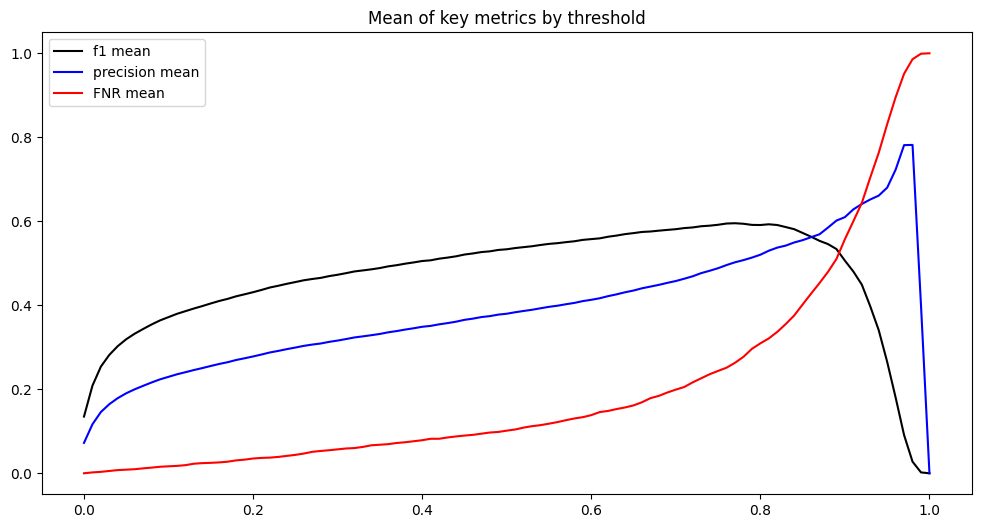

In [40]:
model_eval.create_visual()

In [41]:
model_eval.eval_metrics_

{'f1': np.float64(0.533327273886883),
 'roc_auc': np.float64(0.9518783237697959),
 'ap': np.float64(0.5724652291298129)}

All in all this is a very powerful model. It might be useful to use to it provide the best campaign strategy according to personal data. 

### Out of curiosity, what if I let RFE keep a little more, the default is just 0.5, I will let it go with 0.6 to 0.9 instead. 

This might take longer, I will add step to 0.2. 

In [3]:
xgb_base=XGBClassifier(
    device="cuda", 
    tree_method="hist", 
    eval_metric="aucpr",
    random_state=seed
)

pipe= Pipeline(
    [
        ("data_transform", data_processing.data_transform()), 
        ("data_select", data_processing.data_selector(cut=0.98, how="mi score", mi_n_jobs=1)), 
        ("RFE", RFE(estimator=xgb_base, step=0.2)), 
        ("XGB", XGBClassifier(
            device="cuda", 
            tree_method="hist", 
            eval_metric="aucpr", 
            random_state=seed
        ))
    ]
)

param_dict={
    "RFE__n_features_to_select": [0.6, 0.7, 0.8, 0.9], 
    
    "XGB__max_depth": [3, 4, 5, 6],
    "XGB__min_child_weight": [1, 2, 4, 6],
    "XGB__subsample": np.linspace(0.7, 1.0, 4),
    "XGB__colsample_bytree": np.linspace(0.7, 1.0, 4),
    "XGB__learning_rate": np.geomspace(1e-2, 0.2, 5),
    "XGB__n_estimators": [600, 1000, 1400],  
    "XGB__reg_lambda": np.geomspace(1e-2, 100, 6),
    "XGB__reg_alpha": np.geomspace(1e-3, 10, 6),
    "XGB__gamma": np.linspace(0.0, 5.0, 6),
    "XGB__scale_pos_weight": None # The model_eval will set this 
}

SKF=StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
outer_split=list(SKF.split(X=df_feat, y=df_tar))

In [4]:
model_eval_RFE_tune=training.model_eval(search_method="Random", random_search_n_iter=30, searech_verbose=3)

In [ ]:
model_eval_RFE_tune.eval(df_feat=df_feat, df_tar=df_tar, pipe=pipe, outer_cv=outer_split, param_dict=param_dict)

In [6]:
model_eval_RFE_tune.save_dict("../data/fitted/xgboost/compressed_fitted_dict_xgboost_RFEtune_run1.gz", compress=True)

Data pickled
Data compressed
Fitted dictionary saved


In [7]:
model_eval_RFE_tune.confusion_data_by_threshold(y=df_tar, outer_cv=outer_split)

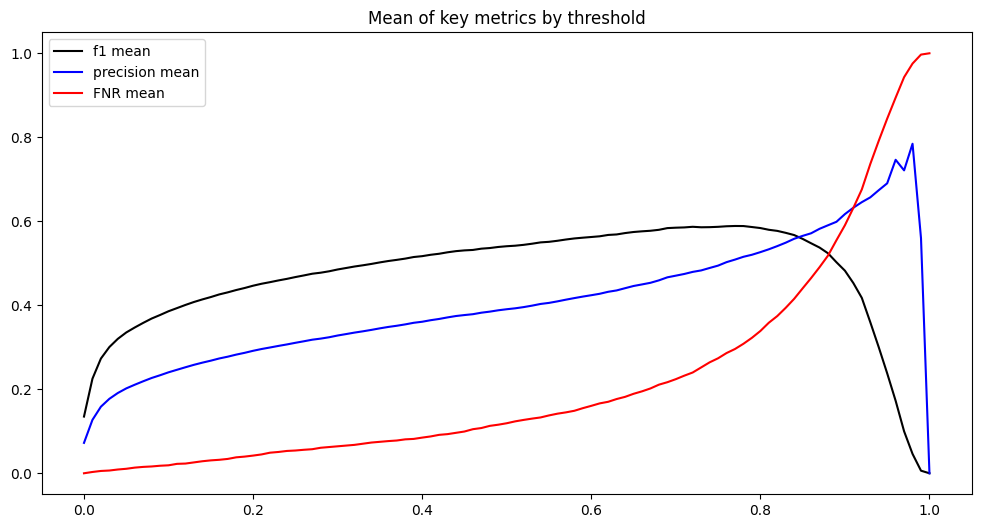

In [8]:
model_eval_RFE_tune.create_visual()

In [9]:
model_eval_RFE_tune.eval_metrics_

{'f1': np.float64(0.540597977375788),
 'roc_auc': np.float64(0.9510028307587012),
 'ap': np.float64(0.5681171101211728)}

Did not really improve too much. 

## We now do it only for the personal data 

With only the personal data, the feature count is reduced to about 24, we will still run with RFE first, but we will run one without RFE to see which might be better. 

In [22]:
xgb_base=XGBClassifier(
    device="cuda", 
    tree_method="hist", 
    eval_metric="aucpr",
    random_state=seed
)

pipe= Pipeline(
    [
        ("data_transform", data_processing.data_transform(per1=True, per2=True, cam1=False, cam2=False)), 
        ("data_select", data_processing.data_selector(cut=0.98, how="mi score", mi_n_jobs=1)), 
        ("RFE", RFE(estimator=xgb_base, step=0.1)), 
        ("XGB", XGBClassifier(
            device="cuda", 
            tree_method="hist", 
            eval_metric="aucpr", 
            random_state=seed
        ))
    ]
)

param_dict={
    "XGB__max_depth": [3, 4, 5, 6],
    "XGB__min_child_weight": [1, 2, 4, 6],
    "XGB__subsample": np.linspace(0.7, 1.0, 4),
    "XGB__colsample_bytree": np.linspace(0.7, 1.0, 4),
    "XGB__learning_rate": np.geomspace(1e-2, 0.2, 5),
    "XGB__n_estimators": [600, 1000, 1400],  
    "XGB__reg_lambda": np.geomspace(1e-2, 100, 6),
    "XGB__reg_alpha": np.geomspace(1e-3, 10, 6),
    "XGB__gamma": np.linspace(0.0, 5.0, 6),
    "XGB__scale_pos_weight": None # The model_eval will set this 
}

SKF=StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
outer_split=list(SKF.split(X=df_feat, y=df_tar))

In [23]:
model_eval_per=training.model_eval(search_method="Random")

This takes 50 mins without gpu. 

In [ ]:
model_eval_per.eval(df_feat=df_feat, df_tar=df_tar, pipe=pipe, outer_cv=outer_split, param_dict=param_dict)

In [6]:
model_eval_per.save_dict("../data/fitted/xgboost/fitted_dict_per_run_1.pkl")

Fitted dictionary saved


In [7]:
fitted_dict_per=model_eval_per.fitted_dict_

In [8]:
fitted_dict_per

{'Fold 1': (Pipeline(steps=[('data_transform', data_transform(cam1=False, cam2=False)),
                  ('data_select',
                   data_selector(cut=0.98, how='mi score', mi_n_jobs=1)),
                  ('RFE',
                   RFE(estimator=XGBClassifier(base_score=None, booster=None,
                                               callbacks=None,
                                               colsample_bylevel=None,
                                               colsample_bynode=None,
                                               colsample_bytree=None,
                                               device='cuda',
                                               early_stopping_rounds=None,
                                               enable_categorical=False...
                                 gamma=np.float64(1.0), grow_policy=None,
                                 importance_type=None,
                                 interaction_constraints=None,
                      

In [24]:
model_eval_per.load_dict(load_path="../data/fitted/xgboost/fitted_dict_per_run_1.pkl")

Loading completed. 


In [25]:
model_eval_per.confusion_data_by_threshold(y=df_tar,outer_cv=outer_split)

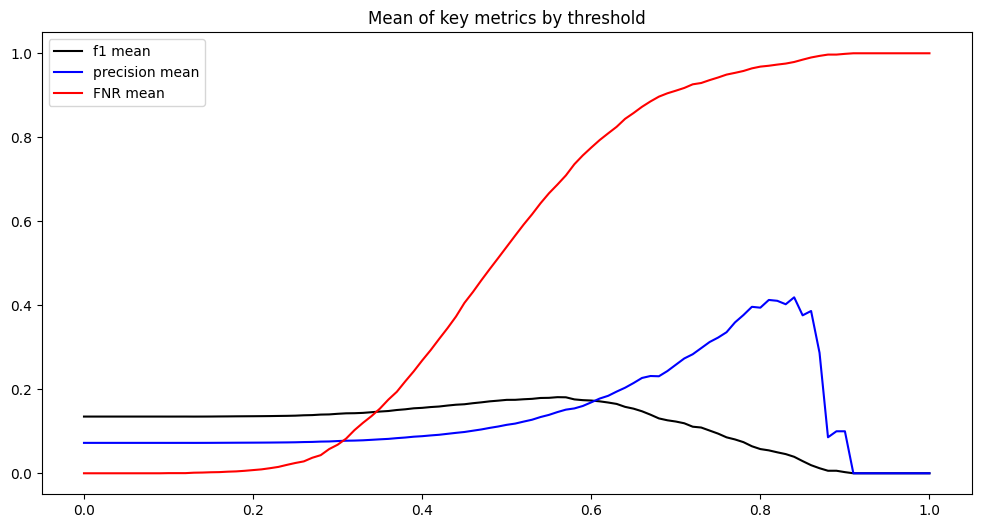

In [26]:
model_eval_per.create_visual()

In [27]:
model_eval_per.eval_metrics_

{'f1': np.float64(0.1748122393580423),
 'roc_auc': np.float64(0.6171669733856983),
 'ap': np.float64(0.1363420313932221)}

This is not a very useful model, at least not at first sight. To get meaningful precision, one has to trade it with very high False Negative rate (not desirable in current context). It might be able to be used in providing a ranking of possible customers so that the company can focus on the most likely customer first. 

Now, without RFE. 

In [28]:
pipe= Pipeline(
    [
        ("data_transform", data_processing.data_transform(per1=True, per2=True, cam1=False, cam2=False)), 
        ("data_select", data_processing.data_selector(cut=0.98, how="mi score", mi_n_jobs=1)), 
        # ("RFE", RFE(estimator=xgb_base, step=0.1)), 
        ("XGB", XGBClassifier(
            device="cuda", 
            tree_method="hist", 
            eval_metric="aucpr", 
            random_state=seed
        ))
    ]
)

param_dict={
    "XGB__max_depth":            [3, 4, 5, 6],
    "XGB__min_child_weight":     [1, 2, 4,6],
    "XGB__reg_lambda":           [0.1, 1, 3, 10, 30],
    "XGB__reg_alpha":            [0, 1e-3, 1e-2, 0.1, 1.0],
    "XGB__gamma":                [0, 1, 3, 5],
    "XGB__subsample":            [0.7, 0.85, 1.0],
    "XGB__colsample_bytree":     [0.6, 0.8, 1.0],
    "XGB__learning_rate":        [0.02, 0.05, 0.1],
    "XGB__n_estimators":         [400, 800, 1200],
    "XGB__scale_pos_weight": None # The model_eval will set this 
}

SKF=StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
outer_split=list(SKF.split(X=df_feat, y=df_tar))

In [29]:
model_eval_per_noRFE=training.model_eval(search_method="Random")

In [ ]:
model_eval_per_noRFE.eval(df_feat=df_feat, df_tar=df_tar, pipe=pipe, outer_cv=outer_split, param_dict=param_dict)

In [10]:
model_eval_per_noRFE.save_dict(save_path="../data/fitted/xgboost/fitted_dict_per_noRFE_run1.pkl")

Fitted dictionary saved


In [30]:
model_eval_per_noRFE.load_dict(load_path="../data/fitted/xgboost/fitted_dict_per_noRFE_run1.pkl")

Loading completed. 


In [31]:
model_eval_per_noRFE.confusion_data_by_threshold(y=df_tar,outer_cv=outer_split)

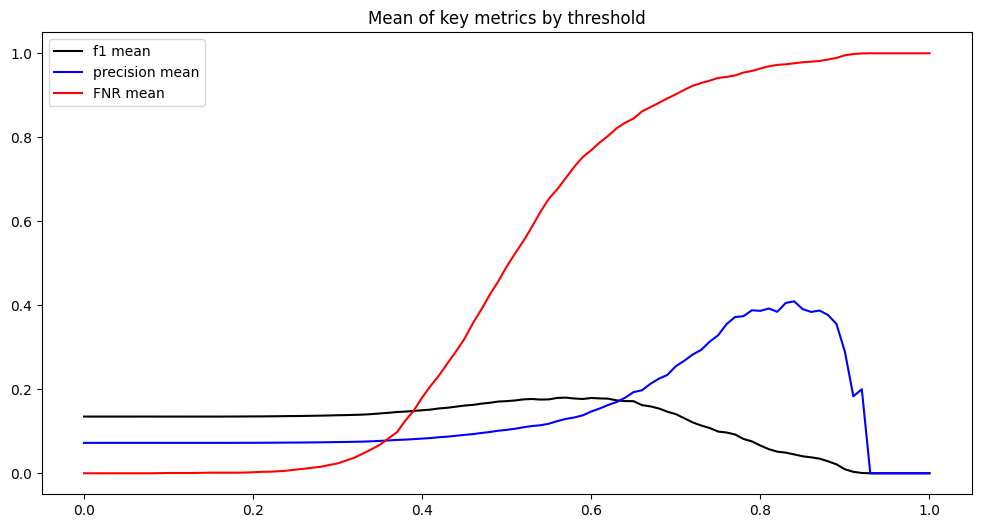

In [32]:
model_eval_per_noRFE.create_visual()

In [33]:
model_eval_per_noRFE.eval_metrics_

{'f1': np.float64(0.17174437613063165),
 'roc_auc': np.float64(0.618567006359507),
 'ap': np.float64(0.13588077676990232)}

This is very small difference with the one with RFE. The key issue is still the un-worthy trade between precision and False Negative rate. 